# Supermasks in Superposition: Training and Task Inference

<img src="images/teaser_supsup.png">

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision
import numpy as np
import math

from tqdm.notebook import tqdm

print("Packages loaded")
# note at edits

Packages loaded


## Training

We train our model using the procedure from "What's Hidden in a Randomly Weighted Neural Network" (Ramanujan et al. 2019). Below is a modification of the layers (using signed constant initialization) from this paper for our continual learning setup. As a deviation from this setup, we assume that an edge (u, v) is included in the subnetwork if its score is greater than 0, rather than use it's absolute magnitude to construct a threshold. 

In [2]:
# Subnetwork forward from hidden networks
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores):
        return (scores >= 0).float()

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g
    
class GetSubnetSparse(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

def mask_init(module):
    scores = torch.Tensor(module.weight.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores


def signed_constant(module):
    fan = nn.init._calculate_correct_fan(module.weight, 'fan_in')
    gain = nn.init.calculate_gain('relu')
    std = gain / math.sqrt(fan)
    module.weight.data = module.weight.data.sign() * std


class MultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(self.scores[self.task])
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinear({self.in_dims}, {self.out_dims})"
    
class MultitaskMaskLinearSparse(nn.Linear):
    def __init__(self, *args, num_tasks=1, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnetSparse.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnetSparse.apply(self.scores[self.task], self.sparsity)
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinearSparse({self.size()})"

In [3]:
class BasisMultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(
                self.scores[0]
            )
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = GetSubnet.apply(
                    self.scores[i]
                )
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinear({self.size()})"

In [4]:
class BasisMultitaskMaskLinearSparse(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnetSparse.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnetSparse.apply(
                self.scores[0], self.sparsity
            )
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = GetSubnetSparse.apply(
                    self.scores[i], self.sparsity
                )
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearSparse({self.size()})"

In [5]:
class BasisMultitaskMaskLinearFrozen(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        for a in self.basis_alphas:
            a.requires_grad = False
        self.basis_alphas.requires_grad = False
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(
                self.scores[0]
            )
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = GetSubnet.apply(
                    self.scores[i]
                )
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearFrozen({self.size()})"

In [6]:
class BasisMultitaskMaskLinearFrozenSparse(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        for a in self.basis_alphas:
            a.requires_grad = False
        self.basis_alphas.requires_grad = False
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnetSparse.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnetSparse.apply(
                self.scores[0], self.sparsity
            )
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = GetSubnetSparse.apply(
                    self.scores[i], self.sparsity
                )
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearFrozenSparse({self.size()})"

In [8]:
ValidConvs = [
    MultitaskMaskLinear,
    MultitaskMaskLinearSparse,
    BasisMultitaskMaskLinear,
    BasisMultitaskMaskLinearSparse,
    BasisMultitaskMaskLinearFrozen,
    BasisMultitaskMaskLinearFrozenSparse
]

def isoftype(m, cls_lst):
    return any([isinstance(m, c) for c in cls_lst])

In [9]:
# Utility functions
def set_model_task(model, task, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Set task of {n} to {task}")
            m.task = task

def cache_masks(model):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Caching mask state for {n}")
            m.cache_masks()

def set_num_tasks_learned(model, num_tasks_learned):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Setting learned tasks of {n} to {num_tasks_learned}")
            m.num_tasks_learned = num_tasks_learned

def set_alphas(model, alphas, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Setting alphas for {n}")
            m.alphas = alphas

## Model

For simplicity we use a simple 3-layer fully connected neural network. Note that you can make any neural by replacing a standard layer with its corresponding mask layer.

In [10]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [11]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFCSparse(nn.Module):
    def __init__(self, hidden_size, num_tasks, sparsity):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinearSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [12]:
# Multitask Model, a simple fully connected model in this case
class BasisMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [13]:
class BasisHiddenOnlyMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [14]:
class BasisHiddenOnlyFrozenMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearFrozen(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearFrozen(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [15]:
# Multitask Model, a simple fully connected model in this case
class BasisSparseMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearSparse(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [16]:
class BasisHiddenOnlySparseMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [17]:
class BasisHiddenOnlySparseFrozenMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearFrozenSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearFrozen(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

## Dataset 

Our "base" dataset is MNIST. Each task is a random permutation of the pixels of MNIST. Namely, given a dataset $\{(x_i, y_i)\}_i$ for each task $t$, we take a random permutation $S^t\in S_{784}$ and construct a dataset $\{(S^t(x_i), y_i)\}_i$. 

Below we show this process and an example of a particular task. `MNISTPerm` uses an update task method to generate a particular sub-task. To assure these splits are reproducible, `MNISTPerm` takes a `seed` argument. In our paper we evaluate on seeds 0 through 4.

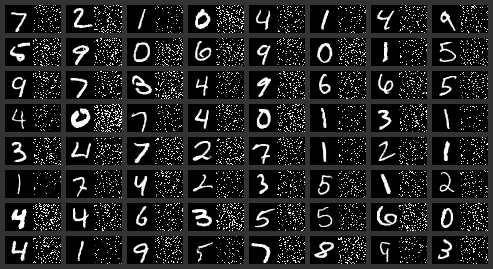

In [8]:
class MNISTPerm:
    class permute(object):
        def __call__(self, tensor):
            out = tensor.flatten()
            out = out[self.perm]
            return out.view(1, 28, 28)

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTPerm, self).__init__()
        
        data_root = "mnist"
        self.permuter = self.permute()
        self.seed = seed
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    self.permuter,
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                        self.permuter,
                    ]
                ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        np.random.seed(i + self.seed)
        self.permuter.__setattr__("perm", np.random.permutation(784))
    
    def unpermute(self):
        self.permuter.__setattr__("perm", np.arange(784))

mnist = MNISTPerm()

# Showing some example images from MNISTPerm
mnist.unpermute()
batch, labels = next(iter(mnist.val_loader))

mnist.update_task(0)
task0, labels = next(iter(mnist.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

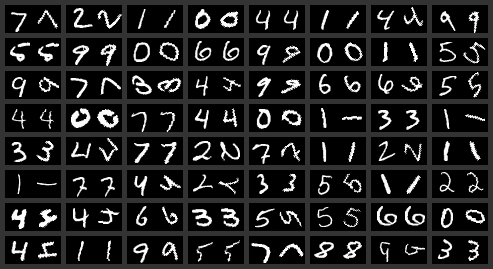

In [9]:
import random

class MNISTRot:
    class rot(object):
        def __call__(self, img):
            if self.rotate:
                return torchvision.transforms.RandomRotation(90)(img)
            return img

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTRot, self).__init__()
        
        data_root = "mnist"
        self.seed = seed
        self.rotator = self.rot()
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    self.rotator,
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                     [
                         self.rotator,
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.1307,), (0.3081,))
                     ]
                 ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        random.seed(i + self.seed)
        self.rotator.__setattr__("rotate", True)
    
    def unrotate(self):
        self.rotator.__setattr__("rotate", False)

mnist_rot = MNISTRot()

# Showing some example images from MNISTPerm
mnist_rot.unrotate()
batch, labels = next(iter(mnist_rot.val_loader))

mnist_rot.update_task(0)
task0, labels = next(iter(mnist_rot.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

### Simple train and evaluation loops for classification

In [10]:
# Finding supermasks per task

def train(model, trainloader, optimizer, epoch):
    model.train()

    criterion = nn.CrossEntropyLoss()
    num_correct = 0
    total_seen = 0
    for i, (batch, labels) in tqdm(
        enumerate(trainloader),
        ascii=True,
        total=len(trainloader)
    ):
        logits = model(batch)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            predictions = logits.argmax(dim=-1)
            num_correct += (predictions == labels).float().sum()
            total_seen += logits.size(0) 
            tqdm.write(
                (f"e{epoch} {i+1}/{len(trainloader)}"
                f" => Loss {loss.item():0.4f}, "
                f"Acc@1 {(num_correct / total_seen):0.4f}"),
                end="\r"
            )


@torch.no_grad()
def evaluate(model, val_loader, epoch):
    model.eval()
    num_correct = 0
    total_seen = 0
    for batch, labels in tqdm(
        val_loader,
        ascii=True,
        total=len(val_loader)
    ):
        logits = model(batch)
        predictions = logits.argmax(dim=-1)
        num_correct += (predictions == labels).float().sum()
        total_seen += logits.size(0) 
    

    tqdm.write(
        f"Val Perf after {epoch + 1} epochs "
        f"Acc@1 {(num_correct / total_seen):0.4f}", 
    )
    return num_correct / total_seen



For any scenario where task ID is given during train time, we simply train each supermask independently, one per task. We make use of our utility function `set_model_task` to do this. We use 5 tasks for demonstration purposes. Feel free to increase `num_tasks` in the following cell. In our paper we use as many as 2500 tasks with no drop in performance for either task inference or validation accuracy.

In [11]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
model = MultitaskFC(hidden_size=300, num_tasks=num_tasks)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model, mnist.val_loader, e)
        
    
    cache_masks(model)
    print()
    set_num_tasks_learned(model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3304, Acc@1 0.8555


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9234
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2478, Acc@1 0.8529


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9254
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3299, Acc@1 0.8561


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9223
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2713, Acc@1 0.8613


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9260
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2664, Acc@1 0.8457


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9264
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2593, Acc@1 0.8623


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9265
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3485, Acc@1 0.8594


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9229
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2515, Acc@1 0.8551


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9229
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4318, Acc@1 0.8636


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9252
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3058, Acc@1 0.8649


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9261
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2764, Acc@1 0.8678


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9285
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2894, Acc@1 0.8571


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9251
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2614, Acc@1 0.8584


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9244
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2859, Acc@1 0.8669


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9230
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2593, Acc@1 0.8551


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9257
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2067, Acc@1 0.8590


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9227
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2981, Acc@1 0.8496


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9218
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2434, Acc@1 0.8643


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9261
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2881, Acc@1 0.8604


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9263
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2913, Acc@1 0.8418


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9250
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [38]:
performance_map = {}

In [44]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9248
Per task performance
Task 0: 0.9234
Task 1: 0.9254
Task 2: 0.9223
Task 3: 0.9260
Task 4: 0.9264
Task 5: 0.9265
Task 6: 0.9229
Task 7: 0.9229
Task 8: 0.9252
Task 9: 0.9261
Task 10: 0.9285
Task 11: 0.9251
Task 12: 0.9244
Task 13: 0.9230
Task 14: 0.9257
Task 15: 0.9227
Task 16: 0.9218
Task 17: 0.9261
Task 18: 0.9263
Task 19: 0.9250


In [45]:
performance_map['supsup_mnist'] = gg_performance.copy()

### MNIST Perm with Sparsity

In [266]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
models = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(models, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in models.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(models, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(models, mnist.val_loader, e)
        
    
    cache_masks(models)
    print()
    set_num_tasks_learned(models, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3344, Acc@1 0.8392


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9134
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4962, Acc@1 0.8421


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9105
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4172, Acc@1 0.8311


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9112
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3272, Acc@1 0.8376


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9079
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4826, Acc@1 0.8369


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9135
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2662, Acc@1 0.8353


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9116
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4406, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9109
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.1645, Acc@1 0.8340


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2586, Acc@1 0.8551


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4018, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9153
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2806, Acc@1 0.8376


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9141
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3099, Acc@1 0.8389


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9147
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3000, Acc@1 0.8457


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9122
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3152, Acc@1 0.8363


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9122
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3632, Acc@1 0.8389


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9053
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4768, Acc@1 0.8291


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9093
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3480, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9097
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3789, Acc@1 0.8350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9118
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3796, Acc@1 0.8395


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9146
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2508, Acc@1 0.8392


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9111
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [267]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(models, task)
    mnist.update_task(task)
    acc1 = evaluate(models, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9116
Per task performance
Task 0: 0.9134
Task 1: 0.9105
Task 2: 0.9112
Task 3: 0.9079
Task 4: 0.9135
Task 5: 0.9116
Task 6: 0.9109
Task 7: 0.9113
Task 8: 0.9113
Task 9: 0.9153
Task 10: 0.9141
Task 11: 0.9147
Task 12: 0.9122
Task 13: 0.9122
Task 14: 0.9053
Task 15: 0.9093
Task 16: 0.9097
Task 17: 0.9118
Task 18: 0.9146
Task 19: 0.9111


In [268]:
performance_map['supsup_mnist_sparsity_25'] = gg_performance.copy()

### MNIST Rotated

In [13]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
model_rot = MultitaskFC(hidden_size=300, num_tasks=num_tasks)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model_rot, task)
    mnist_rot.update_task(task)

    optimizer = optim.RMSprop([p for p in model_rot.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model_rot, mnist_rot.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model_rot, mnist_rot.val_loader, e)
        
    
    cache_masks(model_rot)
    print()
    set_num_tasks_learned(model_rot, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8802, Acc@1 0.6816


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7755
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7023, Acc@1 0.6634


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7818
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7017, Acc@1 0.6491


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7789
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8558, Acc@1 0.6556


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7753
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6947, Acc@1 0.6536


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7566
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7667, Acc@1 0.6527


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7755
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7885, Acc@1 0.6680


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7751
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8172, Acc@1 0.6605


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7799
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8389, Acc@1 0.6657


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7838
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7702, Acc@1 0.6680


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7847
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8262, Acc@1 0.6722


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7769
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9156, Acc@1 0.6449


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7619
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7426, Acc@1 0.6559


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7844
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8253, Acc@1 0.6553


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7843
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7067, Acc@1 0.6706


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7746
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6729, Acc@1 0.6706


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7796
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8166, Acc@1 0.6725


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7830
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6515, Acc@1 0.6660


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7749
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9614, Acc@1 0.6888


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7848
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8477, Acc@1 0.6764


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7713
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [47]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(model_rot, task)
    mnist_rot.update_task(task)
    acc1 = evaluate(model_rot, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7775
Per task performance
Task 0: 0.7763
Task 1: 0.7798
Task 2: 0.7839
Task 3: 0.7713
Task 4: 0.7626
Task 5: 0.7727
Task 6: 0.7822
Task 7: 0.7752
Task 8: 0.7852
Task 9: 0.7813
Task 10: 0.7787
Task 11: 0.7709
Task 12: 0.7815
Task 13: 0.7819
Task 14: 0.7702
Task 15: 0.7845
Task 16: 0.7836
Task 17: 0.7708
Task 18: 0.7839
Task 19: 0.7728


In [48]:
performance_map['supsup_mnist_rot'] = gg_performance.copy()

# Basis Masks 

### Model Initialization (Only New Tasks)

In [15]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [16]:
seed_dict = model.state_dict()
basis_dict = basis_model.state_dict()
load_dict = {k: seed_dict[k] for k in basis_model.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_model.load_state_dict(basis_dict, False)

<All keys matched successfully>

In [17]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model, mnist.val_loader, e)
        
    
    cache_masks(basis_model)
    print()
    set_num_tasks_learned(basis_model, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7601, Acc@1 0.3291


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3957


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8303, Acc@1 0.4251


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4049
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.0481, Acc@1 0.2783


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3473


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8990, Acc@1 0.3460


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3619
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6282, Acc@1 0.3291


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4468


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6969, Acc@1 0.4574


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4501
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8859, Acc@1 0.3405


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3812


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8604, Acc@1 0.3815


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3991
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6791, Acc@1 0.3604


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4153


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.8859, Acc@1 0.4072


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4057
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [49]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7948
Per task performance
Task 0: 0.9234
Task 1: 0.9254
Task 2: 0.9223
Task 3: 0.9260
Task 4: 0.9264
Task 5: 0.9265
Task 6: 0.9229
Task 7: 0.9229
Task 8: 0.9252
Task 9: 0.9261
Task 10: 0.9285
Task 11: 0.9251
Task 12: 0.9244
Task 13: 0.9230
Task 14: 0.9257
Task 15: 0.4049
Task 16: 0.3619
Task 17: 0.4501
Task 18: 0.3991
Task 19: 0.4057


In [50]:
performance_map['basis_mnist'] = gg_performance.copy()

### Model Initialization (Only New Tasks) Sparsity Enabled

In [272]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_models = BasisSparseMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, sparsity=0.25, start_at_optimal=True)

In [273]:
seed_dict = models.state_dict()
basis_dict = basis_models.state_dict()
load_dict = {k: seed_dict[k] for k in basis_models.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_models.load_state_dict(basis_dict, False)

<All keys matched successfully>

In [274]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_models, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_models.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_models, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_models, mnist.val_loader, e)
        
    
    cache_masks(basis_models)
    print()
    set_num_tasks_learned(basis_models, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5478, Acc@1 0.3913


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4439


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6404, Acc@1 0.4525


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4672
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6193, Acc@1 0.3600


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4131


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.7328, Acc@1 0.4134


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4131
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5466, Acc@1 0.3577


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.4346


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6606, Acc@1 0.4499


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4415
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_models, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_models, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['basis_mnist_sparsity_25'] = gg_performance.copy()

### Model Initialization (Only New Tasks, Rotation MNIST)

In [19]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_rot = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [20]:
seed_dictr = model_rot.state_dict()
basis_dictr = basis_model_rot.state_dict()
load_dictr = {k: seed_dictr[k] for k in basis_model_rot.state_dict().keys() if k in seed_dictr.keys()}
basis_dictr.update(load_dictr)
basis_model_rot.load_state_dict(basis_dictr, False)

<All keys matched successfully>

In [21]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_rot, task)
    mnist_rot.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_rot.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_rot, mnist_rot.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_rot, mnist_rot.val_loader, e)
        
    
    cache_masks(basis_model_rot)
    print()
    set_num_tasks_learned(basis_model_rot, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8649, Acc@1 0.7194


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7835


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9070, Acc@1 0.7673


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7851
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7501, Acc@1 0.7357


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7803


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7097, Acc@1 0.7620


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7872
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7523, Acc@1 0.7432


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7864


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8012, Acc@1 0.7852


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7827
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7315, Acc@1 0.7174


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7793


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7141, Acc@1 0.7604


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7769
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6945, Acc@1 0.7386


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7807


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9245, Acc@1 0.7780


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7803
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [52]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_rot, task)
    mnist_rot.update_task(task)
    acc1 = evaluate(basis_model_rot, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7787
Per task performance
Task 0: 0.7763
Task 1: 0.7798
Task 2: 0.7839
Task 3: 0.7713
Task 4: 0.7626
Task 5: 0.7727
Task 6: 0.7822
Task 7: 0.7752
Task 8: 0.7852
Task 9: 0.7813
Task 10: 0.7787
Task 11: 0.7709
Task 12: 0.7815
Task 13: 0.7819
Task 14: 0.7702
Task 15: 0.7850
Task 16: 0.7891
Task 17: 0.7840
Task 18: 0.7797
Task 19: 0.7826


In [53]:
performance_map['basis_mnist_rot'] = gg_performance.copy()

## Except Final Layer

### Model Initialization (Only New Tasks)

In [23]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hid = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [31]:
seed_dict_hid = model.state_dict()
basis_dict_hid = basis_model_hid.state_dict()
load_dict_hid = {k: seed_dict_hid[k] for k in basis_model_hid.state_dict().keys() if k in seed_dict_hid.keys()}
basis_dict_hid.update(load_dict_hid)
basis_model_hid.load_state_dict(basis_dict_hid, False)

<All keys matched successfully>

In [32]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hid.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(3):
        train(basis_model_hid, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hid, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hid)
    print()
    set_num_tasks_learned(basis_model_hid, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.5508, Acc@1 0.7249


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8280


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6937, Acc@1 0.7865


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7982


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9618, Acc@1 0.8040


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.8373
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6697, Acc@1 0.7461


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7764


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3521, Acc@1 0.7897


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7662


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3993, Acc@1 0.7913


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.8105
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6844, Acc@1 0.7344


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7880


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.5632, Acc@1 0.7826


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7987


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7682, Acc@1 0.7946


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6822
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8983, Acc@1 0.7393


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7338


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3736, Acc@1 0.8141


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.8440


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.5603, Acc@1 0.8151


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7532
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.5874, Acc@1 0.7490


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8040


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4111, Acc@1 0.8105


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.8084


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4368, Acc@1 0.8057


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.8224
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [54]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hid, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.8890
Per task performance
Task 0: 0.9234
Task 1: 0.9254
Task 2: 0.9223
Task 3: 0.9260
Task 4: 0.9264
Task 5: 0.9265
Task 6: 0.9229
Task 7: 0.9229
Task 8: 0.9252
Task 9: 0.9261
Task 10: 0.9285
Task 11: 0.9251
Task 12: 0.9244
Task 13: 0.9230
Task 14: 0.9257
Task 15: 0.8373
Task 16: 0.8105
Task 17: 0.6822
Task 18: 0.7532
Task 19: 0.8224


In [55]:
performance_map['basis_hybrid_mnist'] = gg_performance.copy()

### Model Initialization (Only New Tasks) Sparsity Enabled

In [ ]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hids = BasisHiddenOnlySparseMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [ ]:
seed_dict_hid = models.state_dict()
basis_dict_hid = basis_model_hids.state_dict()
load_dict_hid = {k: seed_dict_hid[k] for k in basis_model_hids.state_dict().keys() if k in seed_dict_hid.keys()}
basis_dict_hid.update(load_dict_hid)
basis_model_hids.load_state_dict(basis_dict_hid, False)

In [ ]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hids, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hids.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_hids, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hids, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hids)
    print()
    set_num_tasks_learned(basis_model_hids, task + 1)
    print()

In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hids, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hids, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['basis_hybrid_mnist_sparsity_25'] = gg_performance.copy()

### Model Initialization (Only New Tasks, Rotation MNIST)

In [34]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_roth = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [35]:
seed_dictr = model_rot.state_dict()
basis_dictrh = basis_model_roth.state_dict()
load_dictrh = {k: seed_dictr[k] for k in basis_model_roth.state_dict().keys() if k in seed_dictr.keys()}
basis_dictrh.update(load_dictrh)
basis_model_roth.load_state_dict(basis_dictrh, False)

<All keys matched successfully>

In [36]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_roth, task)
    mnist_rot.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_roth.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(3):
        train(basis_model_roth, mnist_rot.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_roth, mnist_rot.val_loader, e)
        
    
    cache_masks(basis_model_roth)
    print()
    set_num_tasks_learned(basis_model_roth, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9669, Acc@1 0.6243


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7220


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6509, Acc@1 0.7373


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7681


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8128, Acc@1 0.7354


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7053
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2530, Acc@1 0.5521


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6004


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3314, Acc@1 0.5824


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6237


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1173, Acc@1 0.5941


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6187
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8844, Acc@1 0.6224


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7086


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8941, Acc@1 0.7253


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7281


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6960, Acc@1 0.7539


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7911
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9723, Acc@1 0.6325


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7080


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7660, Acc@1 0.7249


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7450


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8134, Acc@1 0.7503


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7776
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8865, Acc@1 0.6276


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7057


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.0621, Acc@1 0.7334


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7375


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7026, Acc@1 0.7480


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.7773
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [56]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_roth, task)
    mnist_rot.update_task(task)
    acc1 = evaluate(basis_model_roth, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7666
Per task performance
Task 0: 0.7763
Task 1: 0.7798
Task 2: 0.7839
Task 3: 0.7713
Task 4: 0.7626
Task 5: 0.7727
Task 6: 0.7822
Task 7: 0.7752
Task 8: 0.7852
Task 9: 0.7813
Task 10: 0.7787
Task 11: 0.7709
Task 12: 0.7815
Task 13: 0.7819
Task 14: 0.7702
Task 15: 0.7137
Task 16: 0.6178
Task 17: 0.7893
Task 18: 0.7755
Task 19: 0.7817


In [99]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_roth, 0)
    mnist_rot.update_task(task)
    acc1 = evaluate(basis_model_roth, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7735
Per task performance
Task 0: 0.7763
Task 1: 0.7721
Task 2: 0.7753
Task 3: 0.7746
Task 4: 0.7747
Task 5: 0.7800
Task 6: 0.7710
Task 7: 0.7736
Task 8: 0.7742
Task 9: 0.7769
Task 10: 0.7759
Task 11: 0.7715
Task 12: 0.7743
Task 13: 0.7758
Task 14: 0.7643
Task 15: 0.7711
Task 16: 0.7736
Task 17: 0.7706
Task 18: 0.7710
Task 19: 0.7732


In [57]:
performance_map['basis_hybrid_mnist_rot'] = gg_performance.copy()

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
df = pd.DataFrame(performance_map)

In [79]:
df.loc[:14, 'Seen'] = True
df.loc[15:, 'Seen'] = False

In [80]:
df = df.drop(['Seed'], axis=1)

In [97]:
df[[c for c in df.columns if not 'rot' in c]].reset_index().rename(columns={'index': 'Task'}).set_index('Task').style.background_gradient(low=df.min().min(), high=df.max().max(), axis=1)

,supsup_mnist,basis_mnist,basis_hybrid_mnist,Seen
Task,,,,
0,0.923400,0.923400,0.923400,True
1,0.925400,0.925400,0.925400,True
2,0.922300,0.922300,0.922300,True
3,0.926000,0.926000,0.926000,True
4,0.926400,0.926400,0.926400,True
5,0.926500,0.926500,0.926500,True
6,0.922900,0.922900,0.922900,True
7,0.922900,0.922900,0.922900,True
8,0.925200,0.925200,0.925200,True


In [98]:
df[[c for c in df.columns if 'rot' in c] + ['Seen']].reset_index().rename(columns={'index': 'Task'}).set_index('Task').style.background_gradient(low=df.min().min(), high=df.max().max(), axis=1)

,supsup_mnist_rot,basis_mnist_rot,basis_hybrid_mnist_rot,Seen
Task,,,,
0,0.776300,0.776300,0.776300,True
1,0.779800,0.779800,0.779800,True
2,0.783900,0.783900,0.783900,True
3,0.771300,0.771300,0.771300,True
4,0.762600,0.762600,0.762600,True
5,0.772700,0.772700,0.772700,True
6,0.782200,0.782200,0.782200,True
7,0.775200,0.775200,0.775200,True
8,0.785200,0.785200,0.785200,True


### Model Initialization (Cross task analysts, retraining last layer) -- Using mask from task 1

In [150]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hidf = BasisHiddenOnlyFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [151]:
custom_state_dict = basis_model_hidf.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [152]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.1']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.1']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.1'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.1']

In [153]:
basis_model_hidf.load_state_dict(custom_state_dict, False)

<All keys matched successfully>

In [154]:
for task in range(0, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hidf.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model_hidf, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hidf, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hidf)
    print()
    set_num_tasks_learned(basis_model_hidf, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2569, Acc@1 0.6781


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7532
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2466, Acc@1 0.9264


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9255
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3622, Acc@1 0.6823


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7264
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2099, Acc@1 0.6797


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7545
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2536, Acc@1 0.6992


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7502
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2599, Acc@1 0.6986


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7388
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4251, Acc@1 0.6702


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7403
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2303, Acc@1 0.6891


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7418
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3831, Acc@1 0.6735


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7159
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3074, Acc@1 0.6859


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7426
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3204, Acc@1 0.6790


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7348
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2982, Acc@1 0.6995


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7444
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3106, Acc@1 0.6895


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7263
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4135, Acc@1 0.6686


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7333
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3660, Acc@1 0.6878


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7275
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4274, Acc@1 0.6774


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7323
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1801, Acc@1 0.6914


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7298
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3168, Acc@1 0.6771


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7155
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4470, Acc@1 0.6465


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7047
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3594, Acc@1 0.6986


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7639
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [155]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidf, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7451
Per task performance
Task 0: 0.7532
Task 1: 0.9255
Task 2: 0.7264
Task 3: 0.7545
Task 4: 0.7502
Task 5: 0.7388
Task 6: 0.7403
Task 7: 0.7418
Task 8: 0.7159
Task 9: 0.7426
Task 10: 0.7348
Task 11: 0.7444
Task 12: 0.7263
Task 13: 0.7333
Task 14: 0.7275
Task 15: 0.7323
Task 16: 0.7298
Task 17: 0.7155
Task 18: 0.7047
Task 19: 0.7639


### Model Initialization (Cross task analysis, no retraining) -- Using mask from task 1

In [156]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hidf = BasisHiddenOnlyFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [157]:
custom_state_dict = basis_model_hidf.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [158]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.1']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.1']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.1'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.1']

In [159]:
basis_model_hidf.load_state_dict(custom_state_dict, False)

<All keys matched successfully>

In [160]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidf, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.1613
Per task performance
Task 0: 0.1073
Task 1: 0.9254
Task 2: 0.1172
Task 3: 0.1276
Task 4: 0.1462
Task 5: 0.1692
Task 6: 0.0631
Task 7: 0.1727
Task 8: 0.1064
Task 9: 0.1177
Task 10: 0.0599
Task 11: 0.0703
Task 12: 0.1214
Task 13: 0.1373
Task 14: 0.2012
Task 15: 0.0746
Task 16: 0.0833
Task 17: 0.1350
Task 18: 0.1045
Task 19: 0.1858


In [204]:
mnist1 = MNISTPerm()
mnist2 = MNISTPerm()
mnist3 = MNISTPerm()
mnist4 = MNISTPerm()

In [207]:
weight_dict = {k: v for k,v in model.state_dict().items() if k.endswith('weight')}

In [208]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 5 # For demonstration purposes, we go up to 2500 in our paper
model1 = MultitaskFC(hidden_size=300, num_tasks=num_tasks)
sd1 = model1.state_dict()
sd1.update(weight_dict)
model1.load_state_dict(sd1)
model2 = MultitaskFC(hidden_size=300, num_tasks=num_tasks)
sd2 = model2.state_dict()
sd2.update(weight_dict)
model2.load_state_dict(sd2)
model3 = MultitaskFC(hidden_size=300, num_tasks=num_tasks)
sd3 = model3.state_dict()
sd3.update(weight_dict)
model3.load_state_dict(sd3)

<All keys matched successfully>

In [209]:
for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model1, task)
    set_model_task(model2, task)
    set_model_task(model3, task)
    mnist1.update_task(task)
    mnist2.update_task(task)
    mnist3.update_task(task)

    optimizer1 = optim.RMSprop([p for p in model1.parameters() if p.requires_grad], lr=1e-4)
    optimizer2 = optim.RMSprop([p for p in model2.parameters() if p.requires_grad], lr=1e-4)
    optimizer3 = optim.RMSprop([p for p in model3.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model1, mnist1.train_loader, optimizer1, e)
        train(model2, mnist2.train_loader, optimizer2, e)
        train(model3, mnist3.train_loader, optimizer3, e)

#         print("Validation")
#         print("============")
#         acc1 = evaluate(model, mnist.val_loader, e)


    cache_masks(model1)
    cache_masks(model2)
    cache_masks(model3)
    print()
    set_num_tasks_learned(model1, task + 1)
    set_num_tasks_learned(model2, task + 1)
    set_num_tasks_learned(model3, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8561
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8451
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8568
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8558
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8561
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5



In [228]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [229]:
from itertools import product

In [235]:
for layer, task in product([0,2,4], [i for i in range(5)]):
    print('Layer: {}, Task: {}, Overlap: {}'.format(layer, task,
        overlap(model2.state_dict()['model.{}.stacked'.format(layer)][task],
                model3.state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Task: 0, Overlap: 0.5113732814788818
Layer: 0, Task: 1, Overlap: 0.511313796043396
Layer: 0, Task: 2, Overlap: 0.5113690495491028
Layer: 0, Task: 3, Overlap: 0.5138393044471741
Layer: 0, Task: 4, Overlap: 0.5115433931350708
Layer: 2, Task: 0, Overlap: 0.5028111338615417
Layer: 2, Task: 1, Overlap: 0.5050110816955566
Layer: 2, Task: 2, Overlap: 0.5040777921676636
Layer: 2, Task: 3, Overlap: 0.5004000067710876
Layer: 2, Task: 4, Overlap: 0.5055555701255798
Layer: 4, Task: 0, Overlap: 0.5098999738693237
Layer: 4, Task: 1, Overlap: 0.5173333287239075
Layer: 4, Task: 2, Overlap: 0.5098333358764648
Layer: 4, Task: 3, Overlap: 0.5102333426475525
Layer: 4, Task: 4, Overlap: 0.5132333040237427


### Model Initialization (All Tasks, Zero start)

In [86]:
num_tasks = 7 # For demonstration purposes, we go up to 2500 in our paper
basis_model = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=5, start_at_optimal=False)

In [88]:
seed_dict = model.state_dict()
basis_dict = basis_model.state_dict()
load_dict = {k: seed_dict[k] for k in basis_model.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_model.load_state_dict(basis_dict, False)

<All keys matched successfully>

In [89]:
for task in range(7):
    print(f"Training for task {task}")
    set_model_task(basis_model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model, mnist.val_loader, e)
        
    
    cache_masks(basis_model)
    print()
    set_num_tasks_learned(basis_model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4129, Acc@1 0.7158


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8939
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6004, Acc@1 0.7243


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8756
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4409, Acc@1 0.7106


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8795
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4672, Acc@1 0.7074


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8598
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4723, Acc@1 0.7223


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8615
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7254, Acc@1 0.1221


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1388
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4990, Acc@1 0.1807


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2016
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7



## Inference

### Scenario GG: Task ID is given at train time and inference time

If task ID is given at inference time, we simply evaluate using the mask we have trained for that ID. This procedure is shown below.

In [8]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(5):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(5):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9253
Per task performance
Task 0: 0.9255
Task 1: 0.9290
Task 2: 0.9222
Task 3: 0.9253
Task 4: 0.9243


### Scenario GNs: Task ID is given at train time but not inference time

We can infer task identity at inference time for arbitrary pieces of data. Here we use the one-shot algorithm described in the paper for simplicity. In short, we assign each learned supermask $M^i$ a weight $\alpha_i$ such that $\sum_{i} \alpha_i = 1$ and $\alpha_i >= 0$. 

Given an example data point $x$ to classify, we can compute our loss as $H = \mathcal{H}\left(f\left(x, \theta \odot \left(\sum_i \alpha_i M^i\right)\right)\right)$ where $f(x, \theta)$ is our neural network which outputs logits and $\mathcal H$ is our entropy function. From here our inferred task is simply 
$$t = \text{argmin}_i \frac{\partial\mathcal{H}}{\partial \alpha_i}.$$

#### Intuition

We can see entropy as a measure of confidence in our prediction. High entropy prediction distributions are very uncertain (close to uniform) and lowest entropy is reached when our distribution is very certain (at a one hot vector). So it stands to reason that supermasks which haven't been trained on the exemplar data will have high entropy. Further, instead of showing each individual supermask $x$, which would be computationally intractible for many tasks, we can show $x$ to a _superposition_ of supermasks and optimize for superposition coefficients $\alpha_i$. Choosing the smallest $\alpha_i$ for our task is essentially greedily moving in the direction of maximal decrease in entropy. 

Below is a simple implementation of oneshot task inference.

In [8]:
# When task info is not provided we can infer it
# here we use the oneshot task inference alg detailed in the paper

def oneshot_task_inference(model, batch, num_tasks):
    # Set task < 0 for inference mode
    set_model_task(model, -1, verbose=False)
    
    # Initialize alphas to uniform
    alphas = torch.ones(num_tasks, 1, 1) / num_tasks
    alphas.requires_grad_(True)
    set_alphas(model, alphas, verbose=False)
    
    logits = model(batch)
    
    # Entropy of logits
    entropy = -(logits.softmax(dim=1) * logits.log_softmax(dim=1)).sum(1).mean()
    
    # Gradient wrt alphas
    g, = autograd.grad(entropy, alphas)
    
    inferred_task = (-g).squeeze().argmax()

    return inferred_task.item()

#### Task inference accuracy

Below we show how accurate task inference is using our oneshot algorithm. If you would like to evaluate on more tasks (we use 5 for demonstration), just modify the `num_tasks` variable in the cell where we declare `MultitaskFC`. 

Here we evaluate task inference on 50 random images per task (the `trials` variable modifies this number) and show we predict the correct task with 100% accuracy. 

In [9]:
# How many examples to show for task inference
num_examples = 1
trials = 50
num_correct = 0
num_seen = 0
for _ in tqdm(range(trials)):
    for task in range(5):
        mnist.update_task(task)
        inferred_task = oneshot_task_inference(
            model,
            batch=next(iter(mnist.val_loader))[0][:num_examples],
            num_tasks=5
        )
        if inferred_task == task:
            num_correct += 1
        num_seen += 1

print(f"Task inference accuracy: {100 * num_correct / num_seen}%")

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'model' is not defined

#### Full inference procedure

Below is an example of how this could be used in an inference pipeline. In this scenario, we use one random image from the validation set to infer task identity $t$ and then evaluate with the appropriate mask $M^t$ on all tasks. We see that there is no drop in performance from the GG scenario. 

Note that for simplicity this is a small deviation from the evaluation setup in our paper. In our paper we use 1 image per batch to determine the task identity of the batch, and evaluate that batch using the inferred task. So task inference needs to be correct more often to match GG performance. We have already shown task inference accuracy is 100% with high probability in the previous cell so we don't need to do that here. 

In [11]:
# Evaluation

num_examples = 1

# After task inference, we just perform the same evaluation procedure as before
gns_performance = []
for task in range(5):
    mnist.update_task(task)
    inferred_task = oneshot_task_inference(
        model,
        batch=next(iter(mnist.val_loader))[0][:num_examples],
        num_tasks=5
    )
    set_model_task(model, inferred_task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gns_performance.append(acc1.item())

clear_output()
avg_acc = (sum(gns_performance) / len(gns_performance))
print(f"=> Average top 1 performance: {100*avg_acc:.4f}%")
print(f"=> Difference from GG performance: "
      f"{(sum(gg_performance) / len(gg_performance) - avg_acc):.4f}")

=> Average top 1 performance: 92.5260%
=> Difference from GG performance: 0.0000
